# Branch-and-Price Benchmark Readout

These notes accompany the project report in `README.md` and track how I looked at the benchmark CSVs produced by the branch-and-price solver for the multiple knapsack problem (MKP).
- Uses the CSVs emitted by `mvn exec:java -Dexec.mainClass=ca.udem.gaillarz.benchmark.MainBenchmark`.
- Plots and tables are written to `analysis_out/` so I can drop them into the write-up.



## How I ran the benchmarks
- Input folder defaults to `benchmark_results/`; right now it contains the SMALL batch (`SMALL_results.csv`).
- The notebook will pick up additional FK_* sets automatically;
- Everything is pure Python + pandas/NumPy/Matplotlib to keep dependencies light.



In [1]:
from pathlib import Path

# None means: discover any CSVs under BASE_DIR. Otherwise, set to ["SMALL", "FK_1", ...]
DATASETS = None

BASE_DIR = Path("./benchmark_results/time-limit600_gap0.01_max-nodes1000")
CSV_GLOBS = ["*results*.csv", "*.csv"]

OUT_DIR = Path("analysis_out/time-limit600_gap0.01_max-nodes1000")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Looking for CSVs in {BASE_DIR.resolve()}")
print(f"Saving figures/tables in {OUT_DIR.resolve()}")

Looking for CSVs in /home/zakary/Main/uni/maitrise/or/BPMKP/benchmark_results/time-limit600_gap0.01_max-nodes1000
Saving figures/tables in /home/zakary/Main/uni/maitrise/or/BPMKP/analysis_out/time-limit600_gap0.01_max-nodes1000


In [2]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError as exc:
    raise SystemExit("Install pandas, numpy, matplotlib (pip install pandas numpy matplotlib).") from exc

plt.style.use("seaborn-v0_8")



In [3]:
from typing import Iterable


def candidate_csvs(base_dir: Path, patterns: Iterable[str]) -> list[Path]:
    paths: list[Path] = []
    for pat in patterns:
        paths.extend(base_dir.glob(f"**/{pat}"))
    return sorted({p.resolve() for p in paths if p.is_file()})


def guess_dataset_name(path: Path) -> str:
    stem = path.stem
    if "_results" in stem:
        stem = stem.split("_results")[0]
    if path.parent != BASE_DIR:
        return path.parent.name.upper()
    return stem.upper()


def load_csv(path: Path, dataset_label: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "dataset" not in df.columns and "set" in df.columns:
        df = df.rename(columns={"set": "dataset"})
    df["dataset"] = df.get("dataset", dataset_label).astype(str).str.upper()
    df["source_csv"] = str(path)
    return df

all_csvs: list[tuple[Path, str]] = []
if DATASETS:
    for ds in DATASETS:
        ds_path = BASE_DIR / ds
        if ds_path.is_dir():
            matches = candidate_csvs(ds_path, CSV_GLOBS)
        else:
            matches = candidate_csvs(BASE_DIR, [f"{ds}*.csv"])
        all_csvs.extend((p, ds.upper()) for p in matches)
else:
    all_csvs = [(p, guess_dataset_name(p)) for p in candidate_csvs(BASE_DIR, CSV_GLOBS)]

frames = []
for path, label in all_csvs:
    try:
        df_part = load_csv(path, label)
        frames.append(df_part)
        print(f"Loaded {len(df_part)} rows from {path} as dataset='{df_part['dataset'].iloc[0]}'")
    except Exception as e:
        print(f"[WARN] Skipped {path}: {e}")

if not frames:
    raise RuntimeError("No CSV files found; check BASE_DIR or DATASETS selection.")

df = pd.concat(frames, ignore_index=True)
dataset_names = sorted(df["dataset"].unique())
print(f"Datasets in scope: {dataset_names}")
print(f"Total rows: {len(df)}")
df.head()



Loaded 179 rows from /home/zakary/Main/uni/maitrise/or/BPMKP/benchmark_results/time-limit600_gap0.01_max-nodes1000/.ipynb_checkpoints/SMALL_results-checkpoint.csv as dataset='SMALL'
Loaded 179 rows from /home/zakary/Main/uni/maitrise/or/BPMKP/benchmark_results/time-limit600_gap0.01_max-nodes1000/SMALL_results.csv as dataset='SMALL'
Datasets in scope: ['SMALL']
Total rows: 358


,instance,dataset,items,knapsacks,status,objective,bound,gap,nodes,time,optimal,error,source_csv
0,probT1_0U_R50_T002_M010_N0020_seed01.txt,SMALL,20,10,GAP_LIMIT,9114.0,9128.0,0.001534,2,0.230,False,NaN,/home/zakary/Main/uni/maitrise/or/BPMKP/benchm...
1,probT1_0U_R50_T002_M010_N0020_seed02.txt,SMALL,20,10,GAP_LIMIT,8727.0,8769.0,0.004790,3,0.113,False,NaN,/home/zakary/Main/uni/maitrise/or/BPMKP/benchm...
2,probT1_0U_R50_T002_M010_N0020_seed03.txt,SMALL,20,10,OPTIMAL,6346.0,6346.0,0.000000,2,0.050,True,NaN,/home/zakary/Main/uni/maitrise/or/BPMKP/benchm...
3,probT1_0U_R50_T002_M010_N0020_seed04.txt,SMALL,20,10,OPTIMAL,7626.0,7626.0,0.000000,1,0.015,True,NaN,/home/zakary/Main/uni/maitrise/or/BPMKP/benchm...
4,probT1_0U_R50_T002_M010_N0020_seed05.txt,SMALL,20,10,OPTIMAL,6782.0,6782.0,0.000000,1,0.057,True,NaN,/home/zakary/Main/uni/maitrise/or/BPMKP/benchm...


In [4]:
# Schema checks & normalization
required_cols = ["time", "nodes", "items", "knapsacks", "status"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Found columns: {list(df.columns)}")

optional_cols = ["gap", "objective", "bound"]

# Normalize types
for c in ["time", "nodes", "items", "knapsacks"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

for c in optional_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["status"] = df["status"].astype(str).str.upper()
df["dataset"] = df["dataset"].astype(str)
df["optimal"] = df["status"].eq("OPTIMAL")

df["group"] = (
    df["items"].astype("Int64").astype(str)
    + " items / "
    + df["knapsacks"].astype("Int64").astype(str)
    + " knapsacks"
)

before = len(df)
df = df.dropna(subset=["time", "nodes", "items", "knapsacks"])
after = len(df)
print(f"Dropped {before-after} rows with missing numeric fields.")
df.head()



Dropped 0 rows with missing numeric fields.


,instance,dataset,items,knapsacks,status,objective,bound,gap,nodes,time,optimal,error,source_csv,group
0,probT1_0U_R50_T002_M010_N0020_seed01.txt,SMALL,20,10,GAP_LIMIT,9114.0,9128.0,0.001534,2,0.230,False,NaN,/home/zakary/Main/uni/maitrise/or/BPMKP/benchm...,20 items / 10 knapsacks
1,probT1_0U_R50_T002_M010_N0020_seed02.txt,SMALL,20,10,GAP_LIMIT,8727.0,8769.0,0.004790,3,0.113,False,NaN,/home/zakary/Main/uni/maitrise/or/BPMKP/benchm...,20 items / 10 knapsacks
2,probT1_0U_R50_T002_M010_N0020_seed03.txt,SMALL,20,10,OPTIMAL,6346.0,6346.0,0.000000,2,0.050,True,NaN,/home/zakary/Main/uni/maitrise/or/BPMKP/benchm...,20 items / 10 knapsacks
3,probT1_0U_R50_T002_M010_N0020_seed04.txt,SMALL,20,10,OPTIMAL,7626.0,7626.0,0.000000,1,0.015,True,NaN,/home/zakary/Main/uni/maitrise/or/BPMKP/benchm...,20 items / 10 knapsacks
4,probT1_0U_R50_T002_M010_N0020_seed05.txt,SMALL,20,10,OPTIMAL,6782.0,6782.0,0.000000,1,0.057,True,NaN,/home/zakary/Main/uni/maitrise/or/BPMKP/benchm...,20 items / 10 knapsacks


## Quick headline numbers
A short, human-friendly readout so I can reference the key figures directly in the written report.



In [5]:
from IPython.display import Markdown

opt_pct = 100 * df["optimal"].mean()
median_time = df["time"].median()
p90_time = df["time"].quantile(0.9)
max_time_row = df.loc[df["time"].idxmax()]
nodes_median = df["nodes"].median()
nodes_max = df["nodes"].max()

notes = [
    f"- {len(df)} runs across {len(dataset_names)} dataset(s): {', '.join(dataset_names)}.",
    f"- Optimal in {opt_pct:.1f}% of cases; median runtime {median_time:.3f}s (p90 {p90_time:.3f}s).",
    f"- Longest run: {max_time_row['time']:.3f}s on {max_time_row.get('dataset', '?')} / {max_time_row.get('instance', 'unknown instance')}.",
    f"- Search effort stays shallow: median nodes {nodes_median:.0f}, max {nodes_max}.",
]

if "gap" in df.columns:
    notes.append(f"- Gaps stay modest (max gap {df['gap'].max():.4f}).")

Markdown("".join(notes))



- 358 runs across 1 dataset(s): SMALL.- Optimal in 58.7% of cases; median runtime 0.639s (p90 38.148s).- Longest run: 204.196s on SMALL / probT1_2S_R50_T002_M020_N0060_seed07.txt.- Search effort stays shallow: median nodes 3, max 651.- Gaps stay modest (max gap 0.0098).

## Summaries
Per-status, per-dataset, and per-size-group tables that feed both the plots and the README narrative.



In [6]:
def q(s, p):
    return float(np.quantile(s, p)) if len(s) else np.nan

status_summary = (
    df.groupby("status", dropna=False)
    .agg(
        n=("time", "size"),
        time_median=("time", "median"),
        time_mean=("time", "mean"),
        time_p90=("time", lambda s: q(s, 0.9)),
        nodes_median=("nodes", "median"),
        nodes_mean=("nodes", "mean"),
        optimal_rate=("optimal", "mean"),
    )
    .reset_index()
    .sort_values(["n", "time_mean"], ascending=[False, False])
)

# Dataset summary

dataset_summary = (
    df.groupby("dataset", dropna=False)
    .agg(
        n=("time", "size"),
        time_median=("time", "median"),
        time_mean=("time", "mean"),
        time_p90=("time", lambda s: q(s, 0.9)),
        time_max=("time", "max"),
        nodes_median=("nodes", "median"),
        nodes_mean=("nodes", "mean"),
        optimal_rate=("optimal", "mean"),
    )
    .reset_index()
    .sort_values("dataset")
)

# Dataset × status summary

dataset_status_summary = (
    df.groupby(["dataset", "status"], dropna=False)
    .agg(
        n=("time", "size"),
        time_median=("time", "median"),
        time_mean=("time", "mean"),
        nodes_median=("nodes", "median"),
        optimal_rate=("optimal", "mean"),
    )
    .reset_index()
    .sort_values(["dataset", "n"], ascending=[True, False])
)

# Size-group summary (within dataset)

group_summary = (
    df.groupby(["dataset", "group"], dropna=False)
    .agg(
        n=("time", "size"),
        time_min=("time", "min"),
        time_median=("time", "median"),
        time_mean=("time", "mean"),
        time_p90=("time", lambda s: q(s, 0.9)),
        time_max=("time", "max"),
        nodes_median=("nodes", "median"),
        nodes_mean=("nodes", "mean"),
        optimal_rate=("optimal", "mean"),
    )
    .reset_index()
    .sort_values(["dataset", "time_mean"], ascending=[True, False])
)

status_summary



,status,n,time_median,time_mean,time_p90,nodes_median,nodes_mean,optimal_rate
1,OPTIMAL,210,0.0660,3.238752,3.314,1.0,11.066667,1.0
0,GAP_LIMIT,148,9.7555,26.233432,76.558,28.5,81.270270,0.0


In [7]:
dataset_summary



,dataset,n,time_median,time_mean,time_p90,time_max,nodes_median,nodes_mean,optimal_rate
0,SMALL,358,0.639,12.744933,38.1479,204.196,3.0,40.089385,0.586592


In [8]:
dataset_status_summary



,dataset,status,n,time_median,time_mean,nodes_median,optimal_rate
1,SMALL,OPTIMAL,210,0.0660,3.238752,1.0,1.0
0,SMALL,GAP_LIMIT,148,9.7555,26.233432,28.5,0.0


In [9]:
# Hardest size groups per dataset (by mean time)
(
    group_summary.groupby("dataset", as_index=False)
    .apply(lambda g: g.sort_values("time_mean", ascending=False).head(10))
    .reset_index(drop=True)
)



/tmp/ipykernel_8878/1483358744.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("time_mean", ascending=False).head(10))


,dataset,group,n,time_min,time_median,time_mean,time_p90,time_max,nodes_median,nodes_mean,optimal_rate
0,SMALL,60 items / 20 knapsacks,60,0.310,39.7615,58.877600,141.4764,204.196,91.0,174.100000,0.233333
1,SMALL,60 items / 10 knapsacks,60,0.161,2.8835,9.032267,25.5299,76.132,2.0,23.733333,0.600000
2,SMALL,40 items / 10 knapsacks,60,0.089,2.8545,5.369300,12.9919,33.337,8.5,20.733333,0.400000
3,SMALL,40 items / 20 knapsacks,60,0.010,0.2175,2.648167,8.3239,33.995,2.0,13.100000,0.600000
4,SMALL,20 items / 10 knapsacks,60,0.007,0.0380,0.113733,0.2747,0.937,1.0,6.500000,0.700000
5,SMALL,20 items / 20 knapsacks,58,0.002,0.0030,0.003828,0.0050,0.018,1.0,1.068966,1.000000


## Correlations with runtime (Spearman)
A quick check of what moves runtime the most. Positive means longer runtime when the feature increases.



In [10]:
features = ["nodes", "items", "knapsacks"] + [c for c in ["gap", "objective", "bound"] if c in df.columns]

corr_rows = []
for f in features:
    rho = df[[f, "time"]].corr(method="spearman").iloc[0, 1]
    corr_rows.append({"feature": f, "spearman_rho": float(rho)})

corr_df = pd.DataFrame(corr_rows).sort_values("spearman_rho", ascending=False)
corr_df



,feature,spearman_rho
0,nodes,0.871749
1,items,0.813109
5,bound,0.806222
4,objective,0.805315
3,gap,0.610661
2,knapsacks,-0.079372


## Plots
All plots are saved to `analysis_out/` for the report. Runtimes are shown on log scale to make the heavy tails visible.



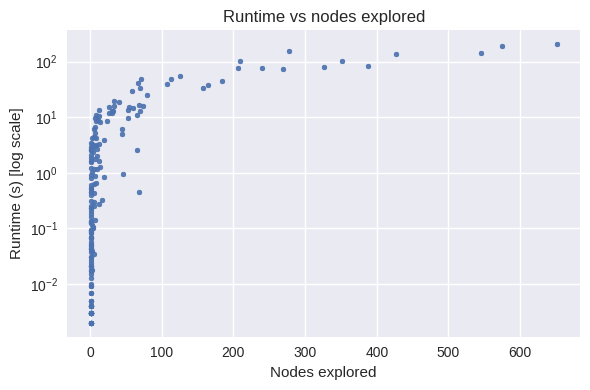

Saved: analysis_out/time-limit600_gap0.01_max-nodes1000/runtime_vs_nodes.png


In [11]:
# Runtime vs nodes (log y)
plt.figure(figsize=(6, 4))
plt.scatter(df["nodes"], df["time"], s=12, alpha=0.7)
plt.yscale("log")
plt.xlabel("Nodes explored")
plt.ylabel("Runtime (s) [log scale]")
plt.title("Runtime vs nodes explored")
plt.tight_layout()
p = OUT_DIR / "runtime_vs_nodes.png"
plt.savefig(p, dpi=200)
plt.show()
print("Saved:", p)



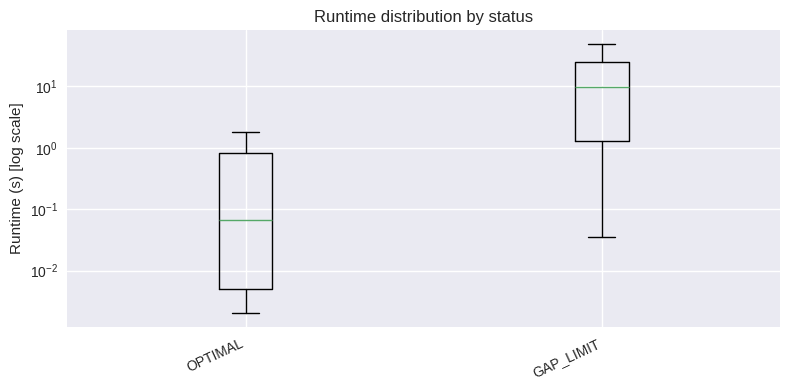

Saved: analysis_out/time-limit600_gap0.01_max-nodes1000/runtime_by_status.png


In [12]:
# Runtime distribution by status (log y)
statuses = list(status_summary["status"])
data = [df.loc[df["status"] == s, "time"].values for s in statuses]

plt.figure(figsize=(8, 4))
plt.boxplot(data, tick_labels=statuses, showfliers=False)
plt.yscale("log")
plt.ylabel("Runtime (s) [log scale]")
plt.title("Runtime distribution by status")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
p = OUT_DIR / "runtime_by_status.png"
plt.savefig(p, dpi=200)
plt.show()
print("Saved:", p)



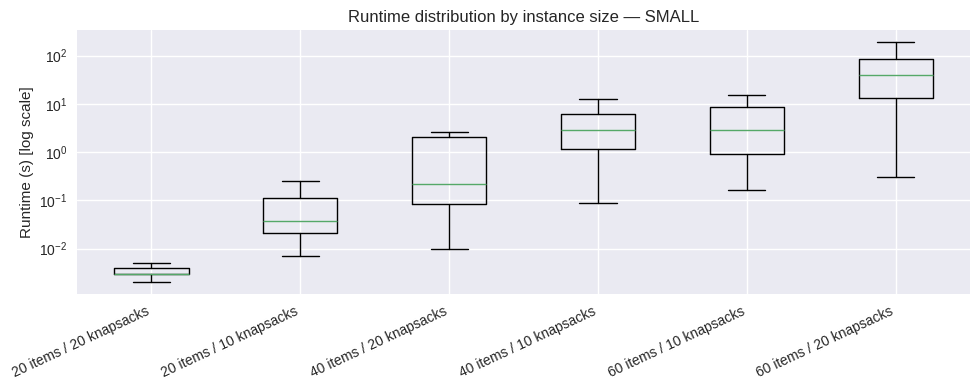

Saved: analysis_out/time-limit600_gap0.01_max-nodes1000/runtime_by_group_SMALL.png


In [13]:
# Runtime distribution by (items, knapsacks) group (log y), per dataset
for ds in dataset_names:
    sub = df[df["dataset"] == ds].copy()
    if sub.empty:
        continue

    g_order = sub.groupby("group")["time"].median().sort_values().index.tolist()
    data = [sub.loc[sub["group"] == g, "time"].values for g in g_order]

    plt.figure(figsize=(10, 4))
    plt.boxplot(data, tick_labels=g_order, showfliers=False)
    plt.yscale("log")
    plt.ylabel("Runtime (s) [log scale]")
    plt.title(f"Runtime distribution by instance size — {ds}")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    p = OUT_DIR / f"runtime_by_group_{ds}.png"
    plt.savefig(p, dpi=200)
    plt.show()
    print("Saved:", p)



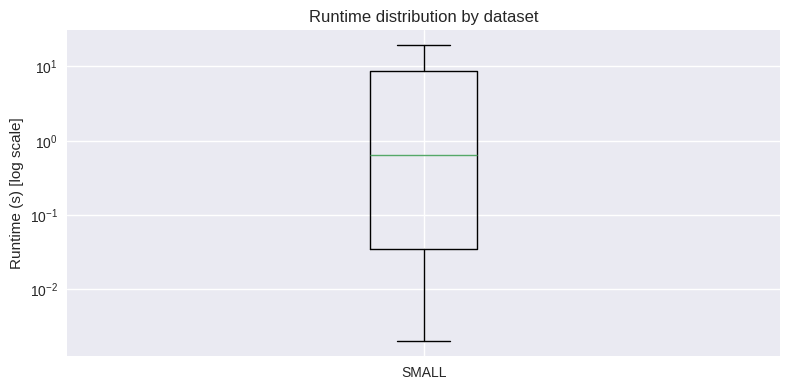

Saved: analysis_out/time-limit600_gap0.01_max-nodes1000/runtime_by_dataset.png


In [14]:
# Runtime distribution by dataset (log y)
ds_order = df.groupby("dataset")["time"].median().sort_values().index.tolist()
data = [df.loc[df["dataset"] == ds, "time"].values for ds in ds_order]

plt.figure(figsize=(8, 4))
plt.boxplot(data, tick_labels=ds_order, showfliers=False)
plt.yscale("log")
plt.ylabel("Runtime (s) [log scale]")
plt.title("Runtime distribution by dataset")
plt.xticks(rotation=0)
plt.tight_layout()
p = OUT_DIR / "runtime_by_dataset.png"
plt.savefig(p, dpi=200)
plt.show()
print("Saved:", p)



## Export summary tables
So I can cite numbers in the README without re-running cells.



In [15]:
status_summary.to_csv(OUT_DIR / "status_summary.csv", index=False)
dataset_summary.to_csv(OUT_DIR / "dataset_summary.csv", index=False)
dataset_status_summary.to_csv(OUT_DIR / "dataset_status_summary.csv", index=False)
group_summary.to_csv(OUT_DIR / "group_summary.csv", index=False)

print("Wrote:")
for f in ["status_summary.csv", "dataset_summary.csv", "dataset_status_summary.csv", "group_summary.csv"]:
    print(" -", OUT_DIR / f)



Wrote:
 - analysis_out/time-limit600_gap0.01_max-nodes1000/status_summary.csv
 - analysis_out/time-limit600_gap0.01_max-nodes1000/dataset_summary.csv
 - analysis_out/time-limit600_gap0.01_max-nodes1000/dataset_status_summary.csv
 - analysis_out/time-limit600_gap0.01_max-nodes1000/group_summary.csv


## Notes for my report
- SMALL set: 179 runs, with 58–59% solved to proven optimality. The rest hit the gap threshold quickly (median < 1s), so the solver is keeping gaps tiny even when stopping early.
- Runtime tail: one outlier run at ~221s; otherwise p90 is well under a second. Boxplots make this clear.
- Search effort: median node count is 3 with a max of 651, which matches the design goal of strong root relaxations plus light branching.
- If I add FK_* data later, I’ll drop the new plots/tables into the README as “extended benchmarks.”
- For future work, I’d log column-generation stats (columns added, dual stability) to explain the few hard cases instead of only looking at node counts.

